In [1]:
%%capture
!pip install statsforecast

In [8]:
##########
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Set environment variable
os.environ['NIXTLA_ID_AS_COL'] = '1'

##########
# Read the data
df = pd.read_csv("https://github.com/cs7649/time-/raw/main/energydata_complete.csv", delimiter=",")

df_nixtla = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

In [9]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [10]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [4]:
df_nixtla.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [13]:
import pandas as pd

# Assuming your DataFrame is named df

# List of columns to convert (excluding 'Date' and 'Time')
columns_to_convert = df.columns.drop(['date'])

# Function to convert comma-separated decimals to dots
def comma_to_dot(x):
    return x.replace(',', '.') if isinstance(x, str) else x

# Apply the conversion column by column
for col in columns_to_convert:
    df[col] = df[col].apply(comma_to_dot).astype(float)


In [18]:
import pandas as pd

# Assuming your DataFrame is named df
# First, combine the Date and Time columns into a single string column
df['ds'] = df['date']

# Convert the combined string to datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d %H:%M:%S')

In [19]:
df = df.drop(columns=["date"])

In [20]:
df.set_index("ds", inplace=True)

In [21]:
df = df.stack().reset_index()

In [22]:
df.columns = ["ds", "unique_id", "y"]
df = df[["unique_id", "ds", "y"]]

In [23]:
df.sort_values(["unique_id","ds"])

,unique_id,ds,y
0,Appliances,2016-01-11 17:00:00,60.000000
28,Appliances,2016-01-11 17:10:00,60.000000
56,Appliances,2016-01-11 17:20:00,50.000000
84,Appliances,2016-01-11 17:30:00,50.000000
112,Appliances,2016-01-11 17:40:00,60.000000
...,...,...,...
552467,rv2,2016-05-27 17:20:00,43.096812
552495,rv2,2016-05-27 17:30:00,49.282940
552523,rv2,2016-05-27 17:40:00,29.199117
552551,rv2,2016-05-27 17:50:00,6.322784


In [24]:
df = df.groupby('unique_id').apply(lambda x: x.resample('H', on='ds').last())

In [25]:
df = df.drop(columns='unique_id').reset_index()

In [26]:
Y_df = df.copy()

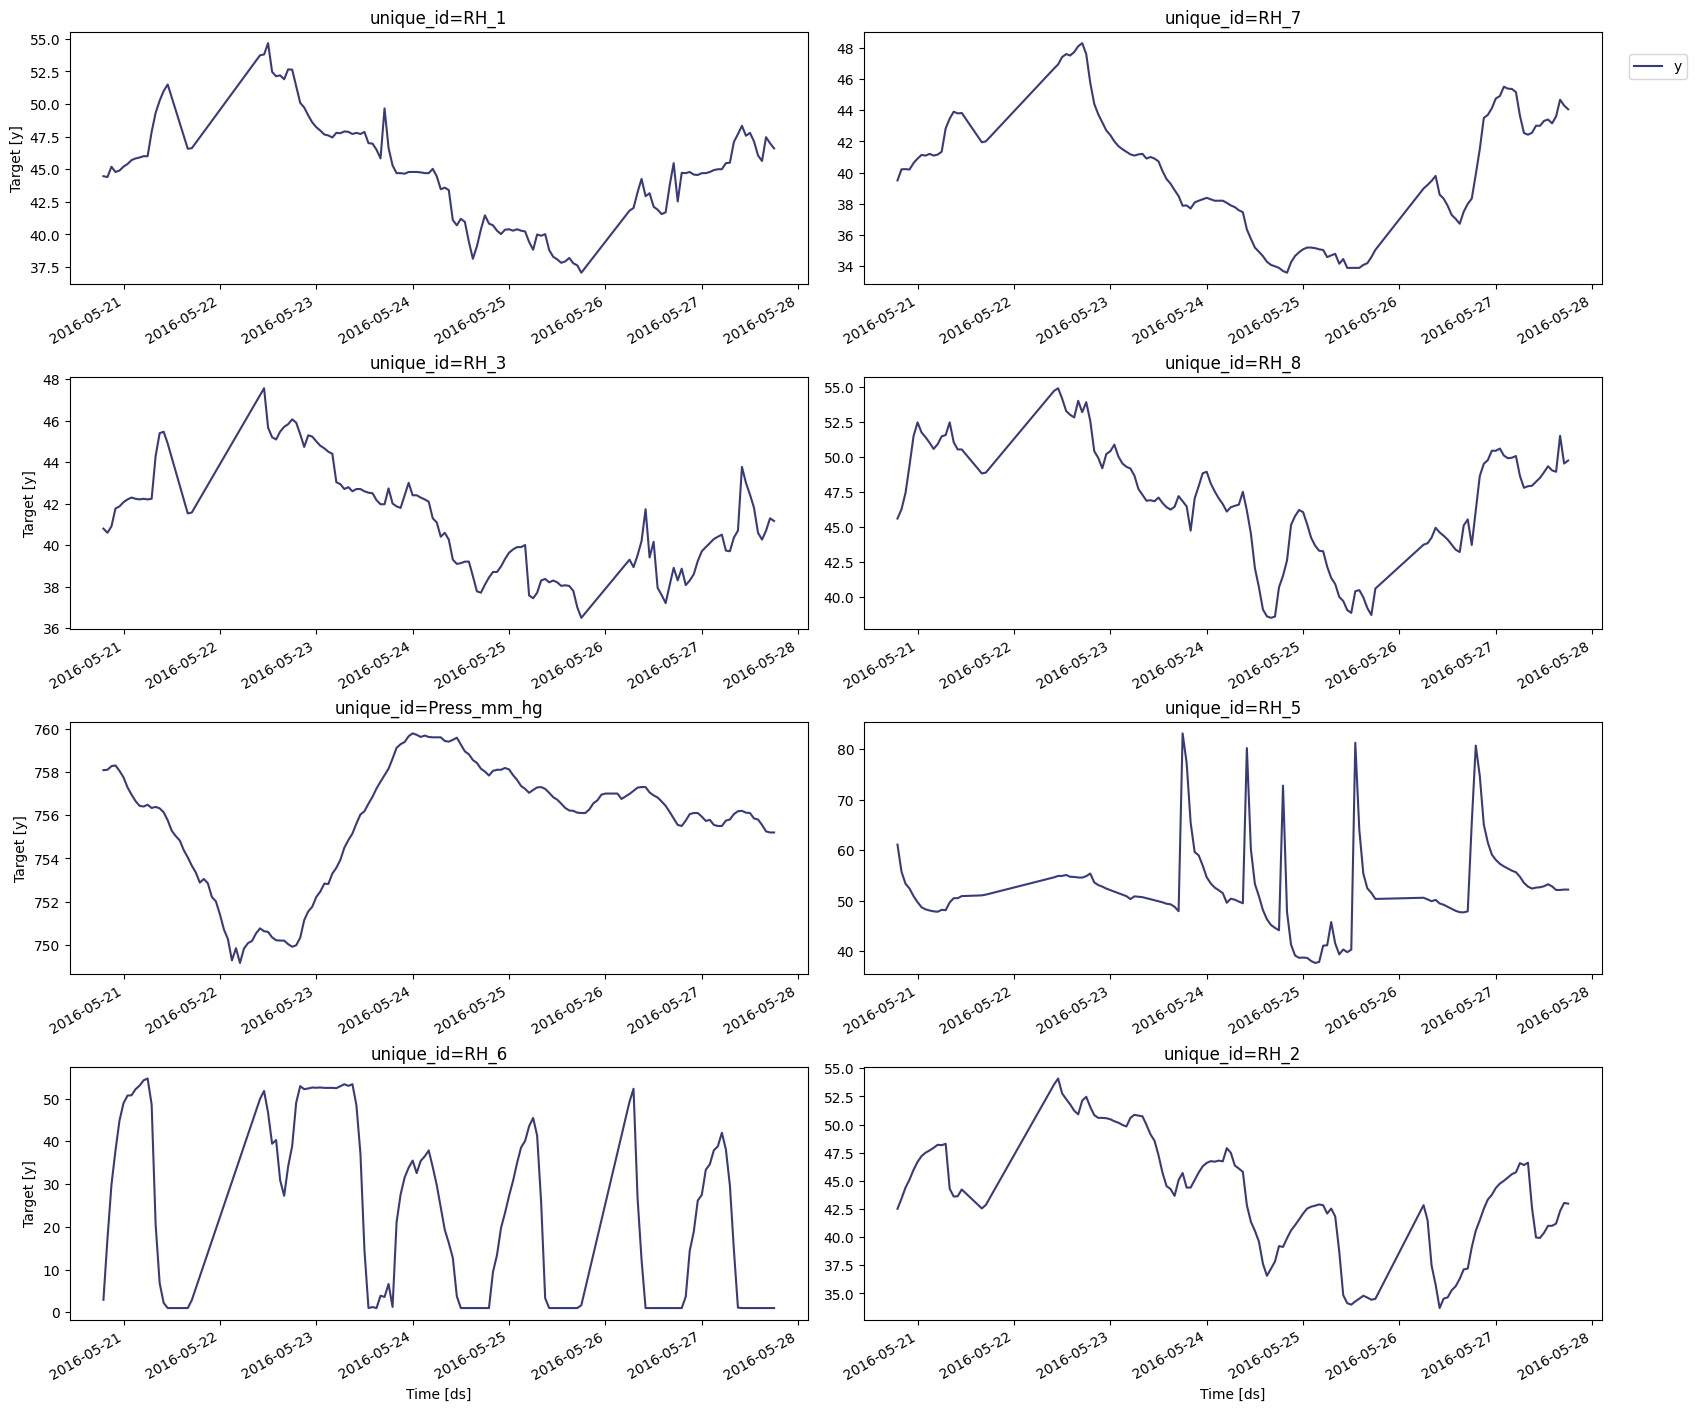

In [27]:
# Select subset of data
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24)

##########
# Explore data
StatsForecast.plot(Y_df)



1. HoltWinters: Triple exponential smoothing, good for data with both trend and seasonality.
1. Croston: Designed for intermittent demand forecasting.
1. SeasonalNaive(season_length=24): Uses the value from the same time in the previous season. The season_length=24 suggests hourly data with daily seasonality.
1. HistoricAverage: Uses the mean of all historical data points.
1. DOT (Dynamic Optimized Theta): A variant of the Theta method, good for data with seasonality.

In [28]:
##########
# Define models
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    # AutoARIMA(season_length=24) ## slightly slow ignoring for now
]

#The season_length=24 refers to hourly data with daily seasonality.

# Instantiate StatsForecast
sf = StatsForecast(
    models=models,
    # freq=1,
    freq='H', # have to add ## freq='D', because dealing with real dates
    fallback_model = SeasonalNaive(season_length=3), ## if other models fail
    n_jobs=-1,
)



* df=Y_df: The input data frame.
* h=48: Forecast horizon of 48 time units (likely 48 hours).
* level=[90]: Generates 90% prediction intervals.

In [29]:
# Generate forecasts
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])

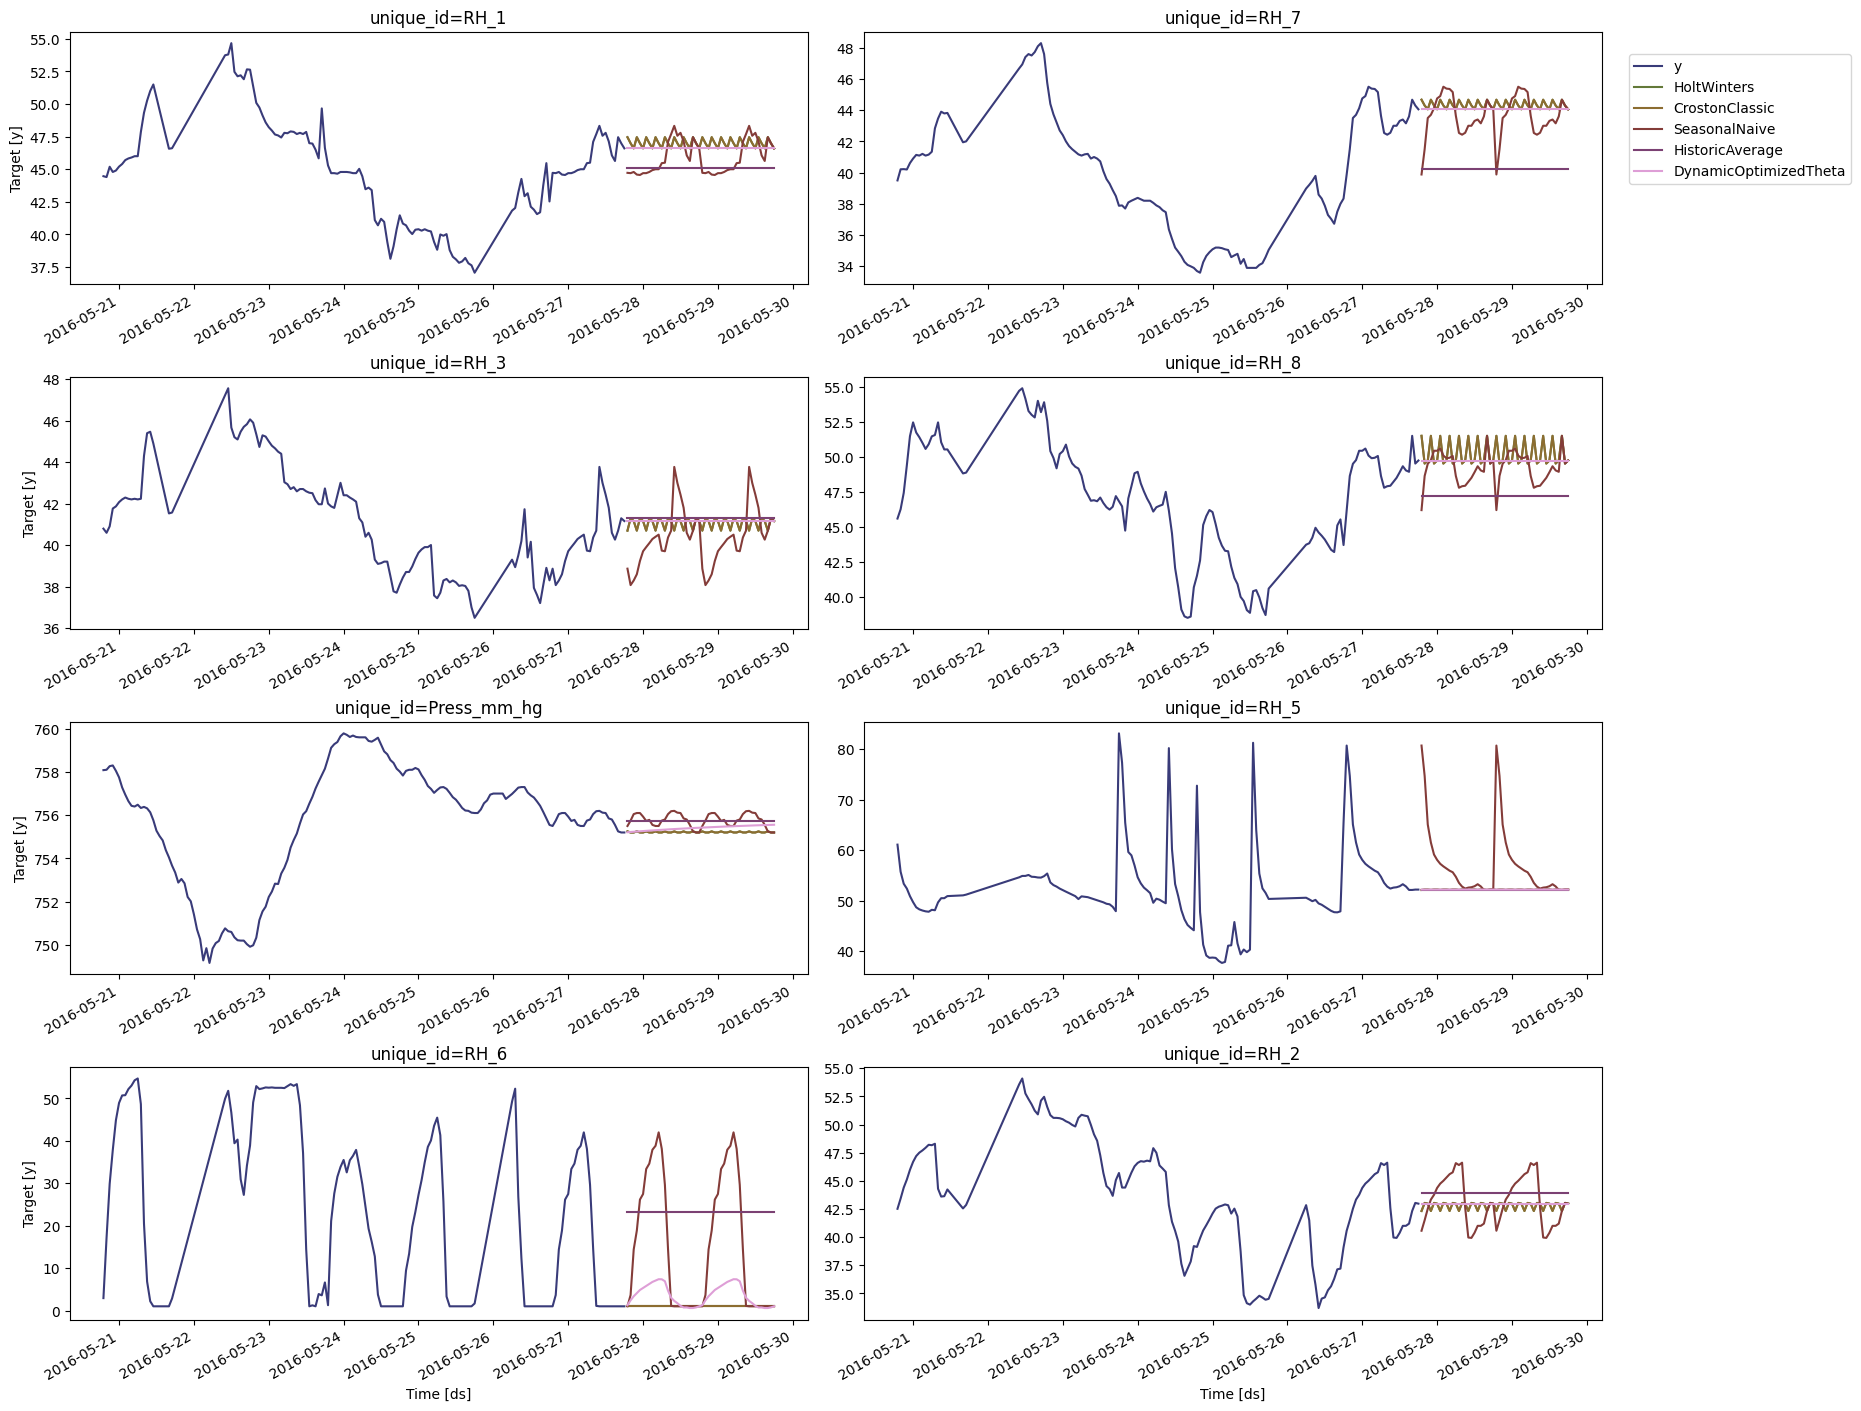

In [30]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

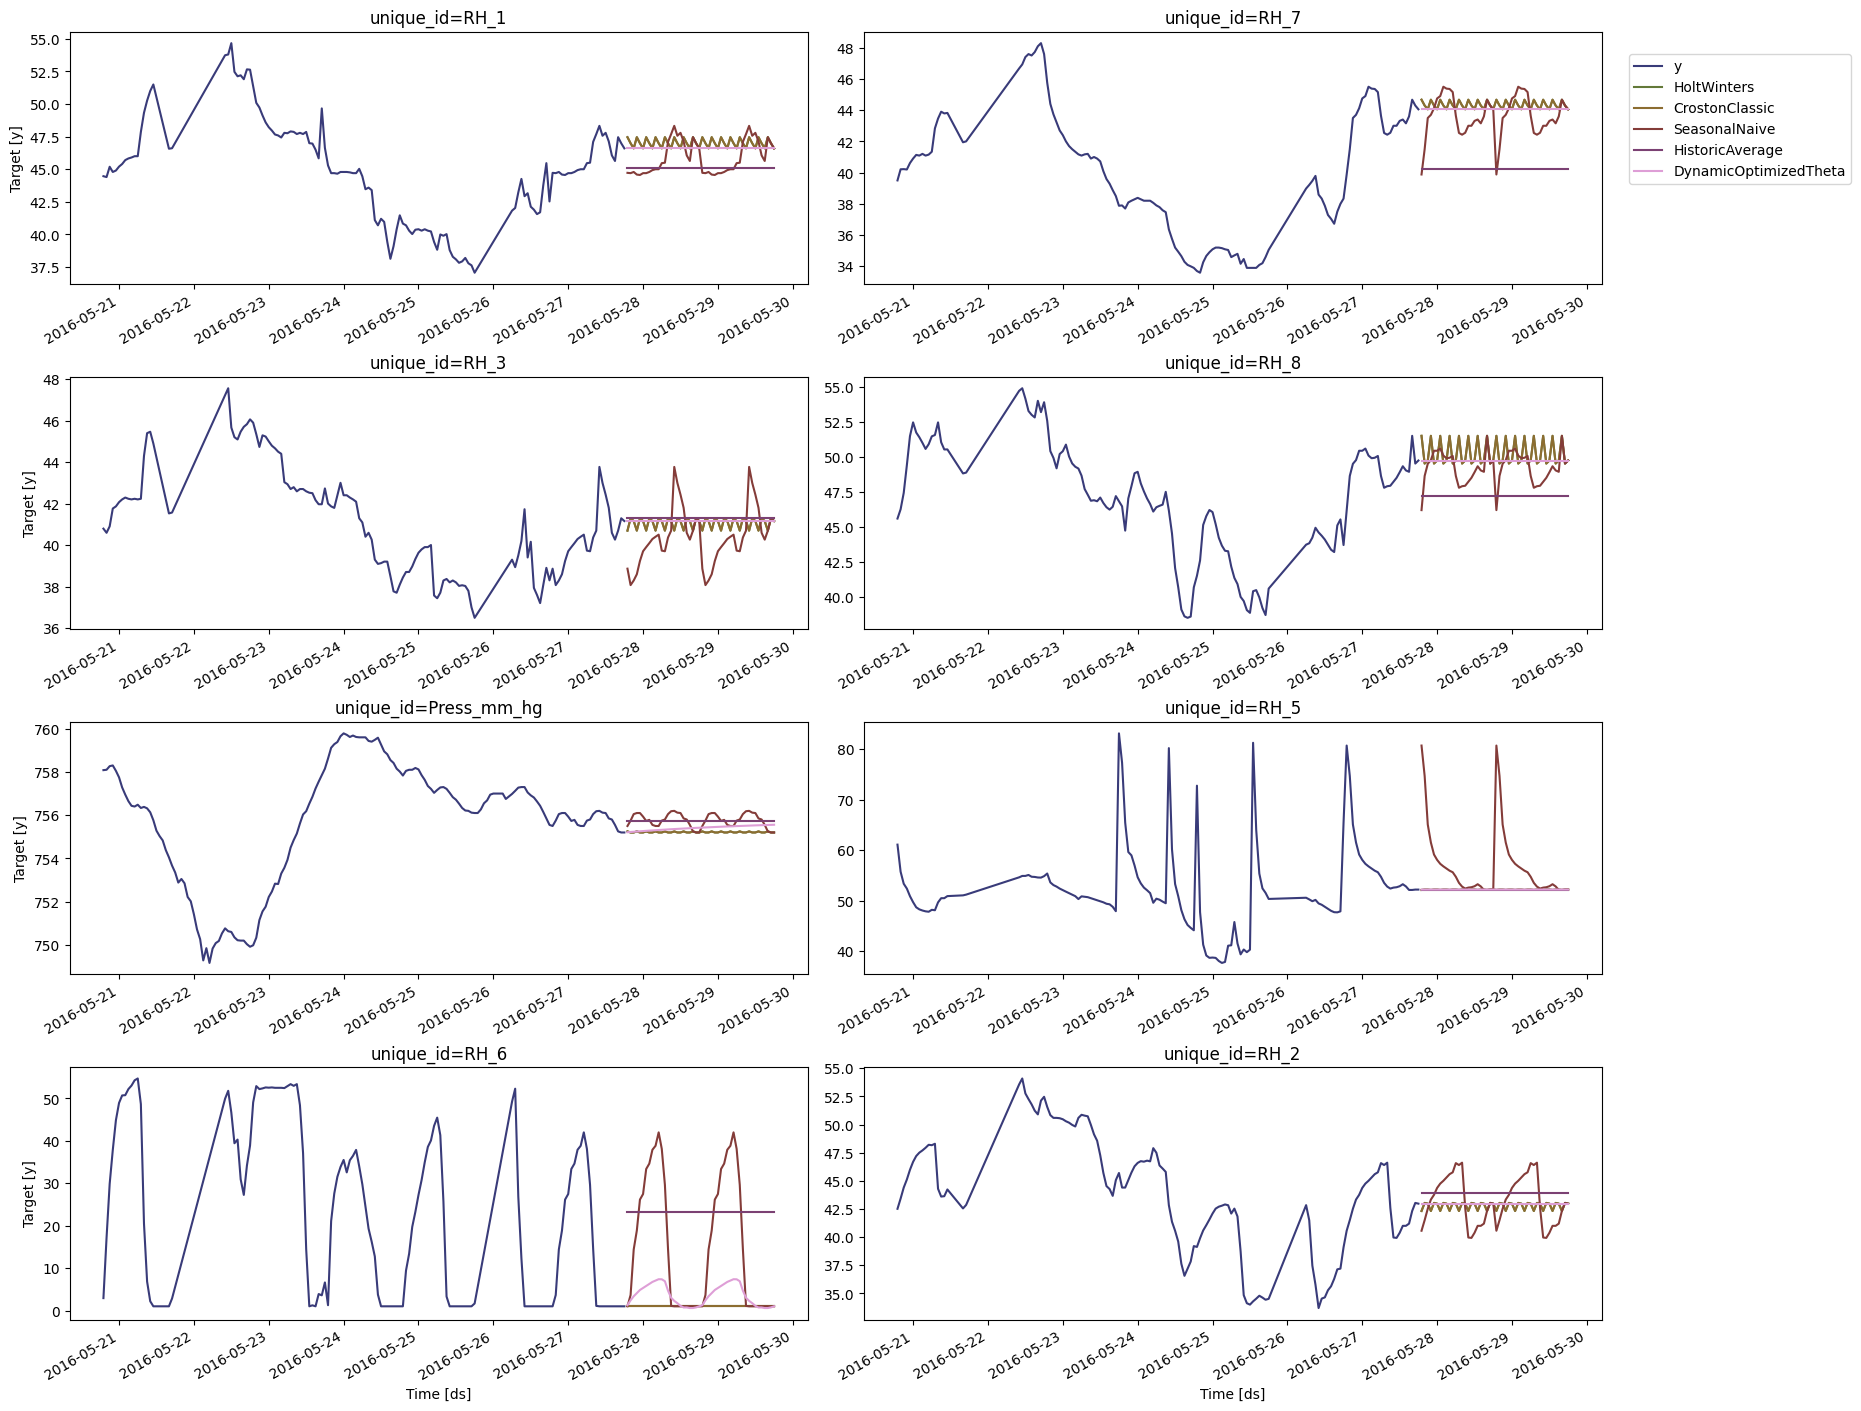

In [31]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

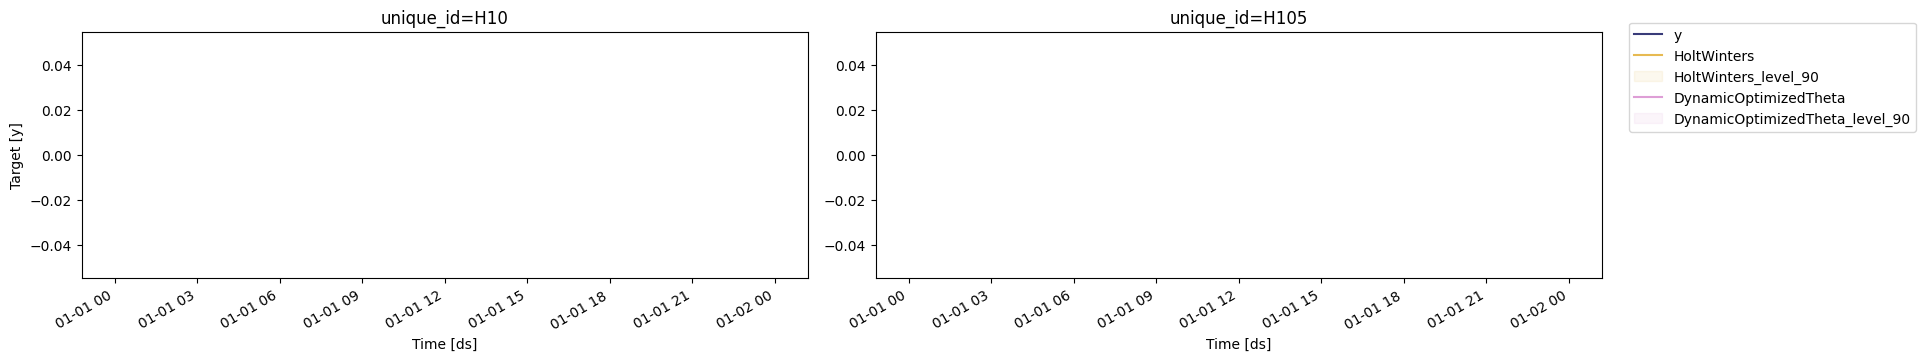

In [32]:
sf.plot(Y_df, forecasts_df, models=["HoltWinters","DynamicOptimizedTheta"], unique_ids=["H10", "H105"], level=[90])


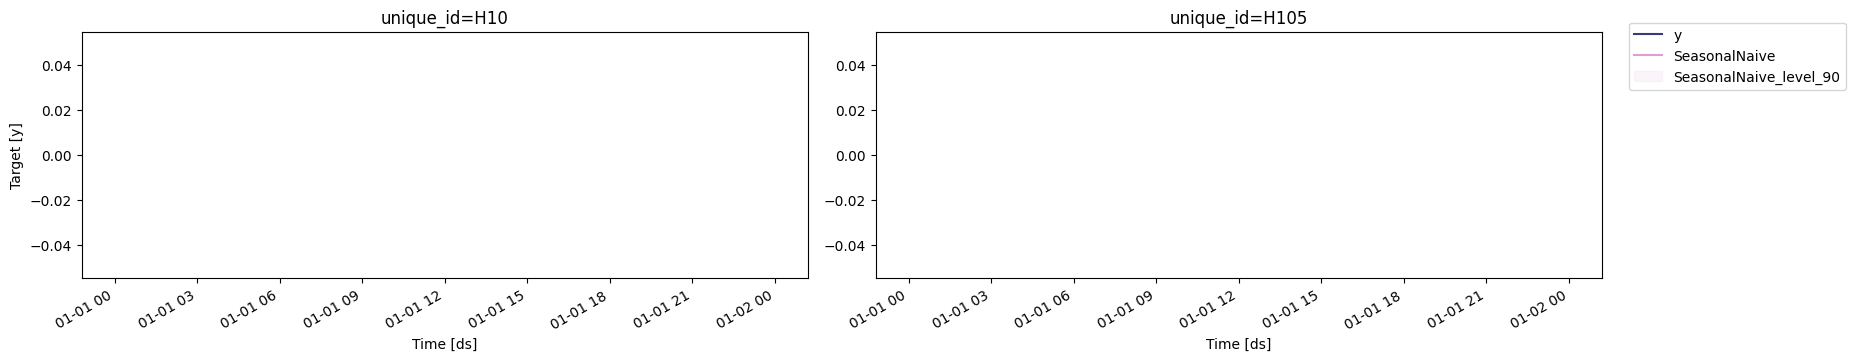

In [33]:
sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])

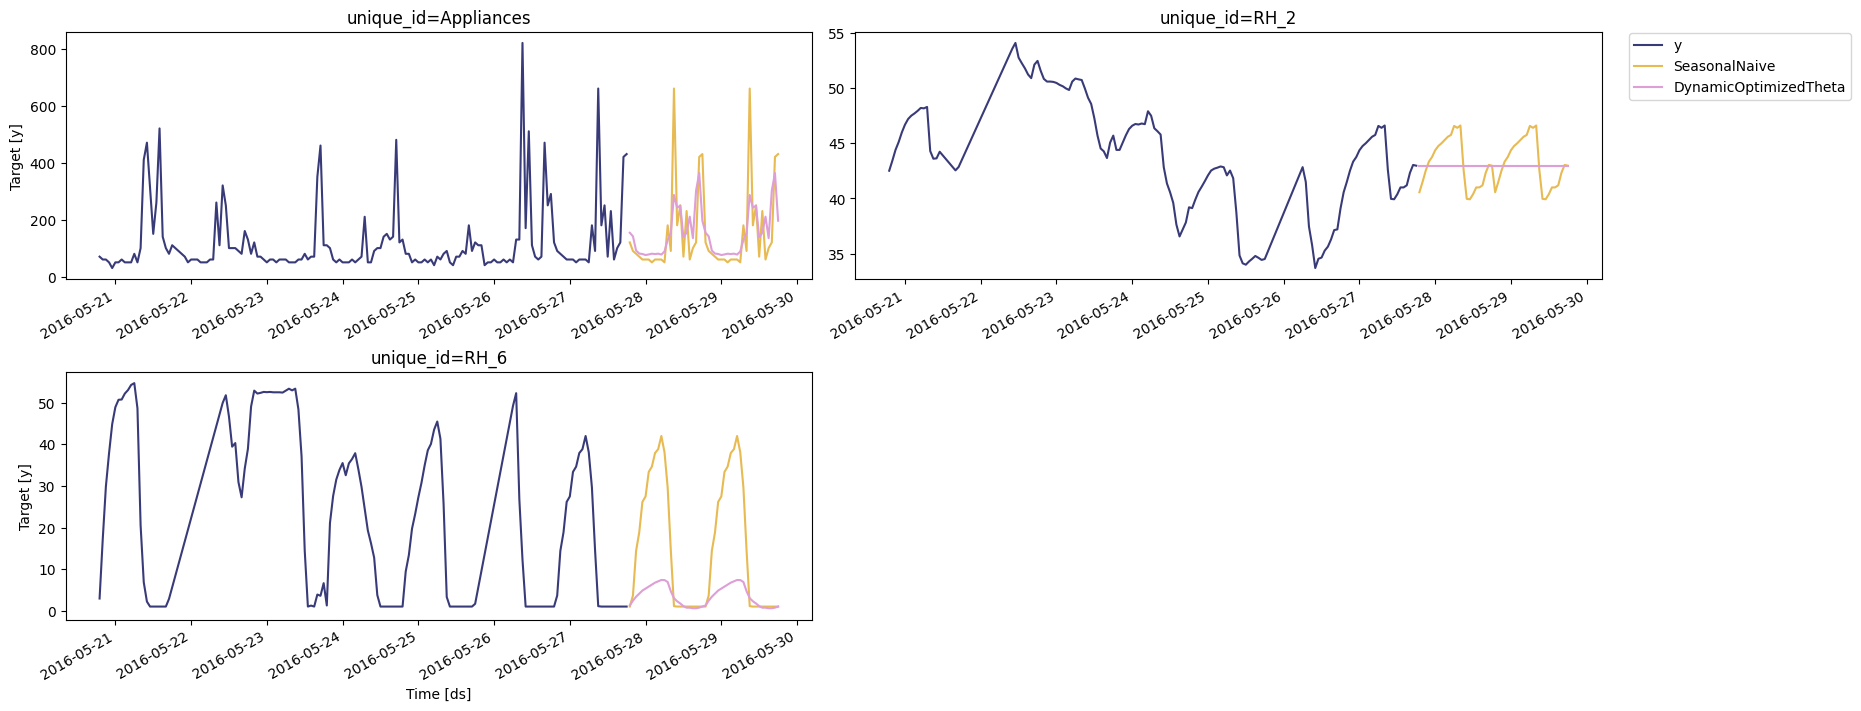

In [34]:
##########
# Cross-validation
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=2
)

##########
# Evaluation function
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True)
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

# Evaluate models
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)

# Create summary
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

# Plot best model for specific IDs
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"').index
sf.plot(Y_df, forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","DynamicOptimizedTheta"])

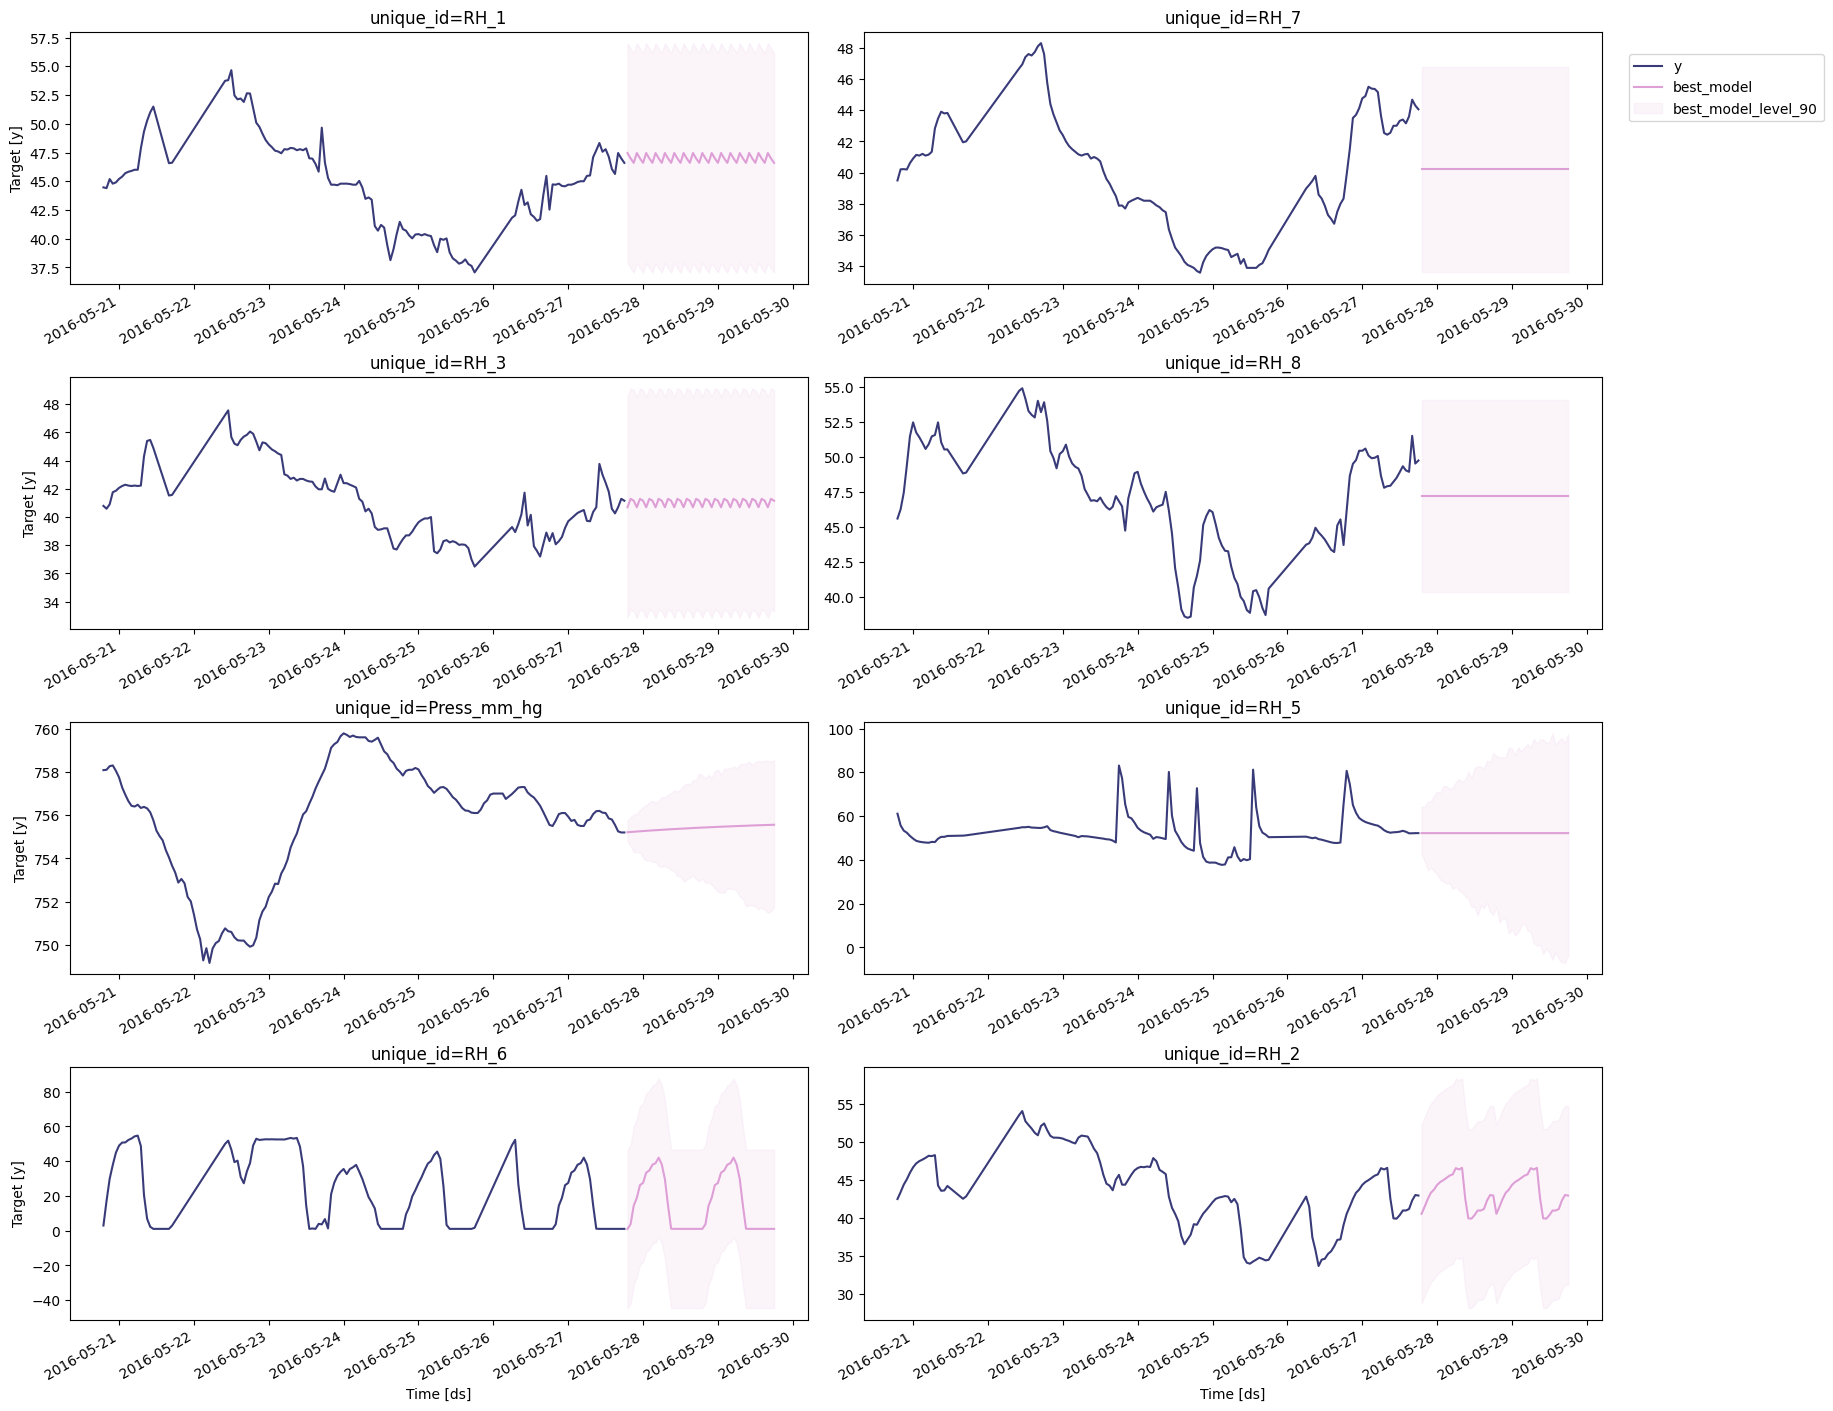

In [35]:
##########
# Select best model for each series
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2)
    df.columns = ['model', 'best_model_forecast']
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

# Get best model forecasts
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

# Plot final results
sf.plot(Y_df, prod_forecasts_df, level=[90])

##########